# SSD300 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD300 for inference on the Pascal VOC datasets. If you'd like more detailed explanations, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from scipy.stats import entropy
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt
import os
import os.path as p
import glob
from PIL import Image
from pathlib import Path

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from keras.layers import TimeDistributed
from keras.models import Model
from ssd_encoder_decoder.ssd_output_decoder_dropout import decode_detections
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.object_detection_2d_image_boxes_validation_utils import BoxFilter

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels

from bounding_box_utils.bounding_box_utils import iou

from tqdm import tqdm_notebook as tqdm

import cv2

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set the image size.
img_height = 300
img_width = 300

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
# Define parameters
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True
n_boxes = 8732
N = 20 # Number of passes through the network

In [4]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)


# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'good_dropout_model/ssd300_dropout_PASCAL2012_train_+12_epoch-58_loss-3.8960_val_loss-5.0832.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

W1210 14:50:35.507322 139908463507264 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1210 14:50:35.509154 139908463507264 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1210 14:50:35.524260 139908463507264 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1210 14:50:35.525569 139908463507264 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_channel_swap (Lambda)     (None, 300, 300, 3)  0           input_mean_normalization[0][0]   
__________________________________________________________________________________________________
conv1_1 (C

Or

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [6]:
ROOT_PATH = '/usr/local/data/msmith/APL/Datasets/PASCAL/'
# The directories that contain the images.
VOC_2007_images_dir      = p.join(ROOT_PATH,'VOCdevkit/VOC2007/JPEGImages/')
VOC_2012_images_dir      = p.join(ROOT_PATH,'VOCdevkit/VOC2012/JPEGImages/')

# The directories that contain the annotations.
VOC_2007_annotations_dir      = p.join(ROOT_PATH,'VOCdevkit/VOC2007/Annotations/')
VOC_2012_annotations_dir      = p.join(ROOT_PATH,'VOCdevkit/VOC2012/Annotations/')

# The paths to the image sets.
VOC_2007_train_image_set_filename    = p.join(ROOT_PATH,'VOCdevkit/VOC2007/ImageSets/Main/train.txt')
VOC_2012_train_image_set_filename    = p.join(ROOT_PATH,'VOCdevkit/VOC2012/ImageSets/Main/train.txt')
VOC_2007_val_image_set_filename      = p.join(ROOT_PATH,'VOCdevkit/VOC2007/ImageSets/Main/val.txt')
VOC_2012_val_image_set_filename      = p.join(ROOT_PATH,'VOCdevkit/VOC2012/ImageSets/Main/val.txt')
VOC_2007_trainval_image_set_filename = p.join(ROOT_PATH,'VOCdevkit/VOC2007/ImageSets/Main/trainval.txt')
VOC_2012_trainval_image_set_filename = p.join(ROOT_PATH,'VOCdevkit/VOC2012/ImageSets/Main/trainval.txt')
VOC_2007_test_image_set_filename     = p.join(ROOT_PATH,'VOCdevkit/VOC2007/ImageSets/Main/test.txt')

classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

dataset = DataGenerator(load_images_into_memory=True)
dataset.parse_xml(images_dirs=[VOC_2012_images_dir],
                  image_set_filenames=[VOC_2012_val_image_set_filename],
                  annotations_dirs=[VOC_2012_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False,
                  )

Loading images into memory: 100%|██████████| 5823/5823 [01:09<00:00, 83.63it/s] 


In [7]:
# Redefine resize because default version has weird behaviour
class Resize:
    '''
    Resizes images to a specified height and width in pixels.
    '''

    def __init__(self,
                 height,
                 width,
                 interpolation_mode=cv2.INTER_LINEAR,
                 box_filter=None,
                 labels_format={'class_id': 0, 'xmin': 1, 'ymin': 2, 'xmax': 3, 'ymax': 4}):
        '''
        Arguments:
            height (int): The desired height of the output images in pixels.
            width (int): The desired width of the output images in pixels.
            interpolation_mode (int, optional): An integer that denotes a valid
                OpenCV interpolation mode. For example, integers 0 through 5 are
                valid interpolation modes.
            box_filter (BoxFilter, optional): Only relevant if ground truth bounding boxes are given.
                A `BoxFilter` object to filter out bounding boxes that don't meet the given criteria
                after the transformation. Refer to the `BoxFilter` documentation for details. If `None`,
                the validity of the bounding boxes is not checked.
            labels_format (dict, optional): A dictionary that defines which index in the last axis of the labels
                of an image contains which bounding box coordinate. The dictionary maps at least the keywords
                'xmin', 'ymin', 'xmax', and 'ymax' to their respective indices within last axis of the labels array.
        '''
        if not (isinstance(box_filter, BoxFilter) or box_filter is None):
            raise ValueError("`box_filter` must be either `None` or a `BoxFilter` object.")
        self.out_height = height
        self.out_width = width
        self.interpolation_mode = interpolation_mode
        self.box_filter = box_filter
        self.labels_format = labels_format

    def __call__(self, image, labels=None, return_inverter=False):

        img_height, img_width = image.shape[:2]

        xmin = self.labels_format['xmin']
        ymin = self.labels_format['ymin']
        xmax = self.labels_format['xmax']
        ymax = self.labels_format['ymax']

        image = cv2.resize(image,
                           dsize=(self.out_width, self.out_height),
                           interpolation=self.interpolation_mode)

        if return_inverter:
            def inverter(labels):
                labels = np.copy(labels)
                labels[:, [ymin, ymax]] = np.round(labels[:, [ymin, ymax]] * (img_height / self.out_height), decimals=0)
                labels[:, [xmin, xmax]] = np.round(labels[:, [xmin, xmax]] * (img_width / self.out_width), decimals=0)
                return labels

        if labels is None:
            if return_inverter:
                return image, inverter
            else:
                return image
        else:
            labels = np.copy(labels)
            labels[:, [ymin, ymax]] = np.round(labels[:, [ymin, ymax]] * (self.out_height / img_height), decimals=0)
            labels[:, [xmin, xmax]] = np.round(labels[:, [xmin, xmax]] * (self.out_width / img_width), decimals=0)

            if not (self.box_filter is None):
                self.box_filter.labels_format = self.labels_format
                labels = self.box_filter(labels=labels,
                                         image_height=self.out_height,
                                         image_width=self.out_width)

            if return_inverter:
                return image, labels, inverter
            else:
                return image, labels

In [8]:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height,width=img_width, labels_format={'class_id': 0, 'xmin': -4, 'ymin': -3, 'xmax': -2, 'ymax': -1})

transformations = [convert_to_3_channels, resize]

batch_size = 128
generator = dataset.generate(batch_size=batch_size,
                                         shuffle=False,
                                         transformations=transformations,
                                         label_encoder=None,
                                         returns={'original_images',
                                                  'processed_images',
                                                  'image_ids',
                                                  'evaluation-neutral',
                                                  'inverse_transform',
                                                  'original_labels'},
                                         keep_images_without_gt=True,
                                         degenerate_box_handling='remove')

## 3. Make predictions

In [9]:
n_images = dataset.get_dataset_size()
#n_images = 3*batch_size
n_batches = int(np.ceil(n_images / batch_size))

In [10]:
save_dir = '/usr/local/data/msmith/APL/dropout_object_detect/'
os.makedirs(save_dir, exist_ok=True)

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

In [11]:
def runGPUPredictions(generator, n_batches, N):
    output = []
    for _ in tqdm(range(n_batches)):
        batch_X, batch_image_ids, batch_eval_neutral, batch_inverse_transforms, original_X, batch_orig_labels = next(generator)
    
        # After below for loop: nested list (Num passes, batch size)
        # Each element : np array (num_detections, num_class+6)
        model_out = []
        for n in range(N):
            model_out.append(decode_detections(model.predict(batch_X), confidence_thresh=0.1, 
                                               iou_threshold=0.1, top_k=200, normalize_coords=normalize_coords, 
                                               img_height=img_height, img_width=img_width))
        # Now list is an array (Num passes, batch size)
        model_out = np.array(model_out)
        
        output.append((batch_X, batch_image_ids, batch_eval_neutral, batch_inverse_transforms, original_X, batch_orig_labels, model_out))
    return output

In [12]:
def runInference(gpuOut, saveFigures=True, iou_threshold=0.95):
    results = []
    for b in tqdm(range(n_batches)):
        batch_X, batch_image_ids, batch_eval_neutral, batch_inverse_transforms, original_X, batch_orig_labels, model_out = gpuOut[b]
        bs = len(batch_X)

        # model_out is an array (Num passes, batch size)

        # Indexing : [image #][observation #]
        # Note that each image will have different numbers of observations
        # Each observation is an array with shape (num_detections, num_class+6)
        observations_per_img = []

        # Iterate over each batch image
        for i in range(bs):
            filtered = [c for c in model_out[:,i] if 0 not in c.shape]
            if len(filtered) == 0:
                concated = np.empty((0))
            else:
                concated =  np.concatenate(filtered)
            # Concated is now an array of shape (total num detections, num_class + 6)
            # Note that there will be many overlaps; we are now trying to remove them

            observations = []
            while concated.shape[0] > 0:
                # Get first bounding box
                box = concated[0, :]
                # Calculate IoU for between said first box an all others
                ious = iou(concated[:, -4:], box[-4:], coords='corners', border_pixels='half', mode='element-wise')
                # Get matches, guaranteed one match min. to itself
                keep_idx = ious >= iou_threshold
                # Add box to list of boxes
                # This way we are grouping all overlapping boxes
                observations.append(concated[keep_idx, :])
                # Remove the boxes we just found were overlapping (min. itself) and keep going
                concated = concated[np.invert(keep_idx),:]
            observations_per_img.append(observations)

        # Get label probabilities
        observations_decoded_per_img = []
        for i in range(bs):
            observations_decoded = []
            for obs in observations_per_img[i]:
                # in observation: index 0-class id of max, 1-confidence of said class, 2-23 inclusive: softmax values, 24-27: box coordinates
                means = np.mean(obs[:,2:], axis=0) # Get mean values of softmax and boxes per paper
                ent = entropy(means[:-4]) # Get uncertainty estimate using entropy of mean (total uncertainty)
                # Max entropy of 21 values slightly greater than 3
                # Min is 0 obviously
                new_class = np.argmax(means[1:-4]) + 1 # Get max class (ignoring background)
                new_obs = np.empty((7))
                new_obs[0:3] = [new_class, means[new_class] , ent]
                new_obs[3:7] = means[-4:]
                # New format: class id, associated class softmax confidence, entropy value, bounding box values
                observations_decoded.append(new_obs)
            observations_decoded = np.array(observations_decoded)
            # If not empty
            if len(observations_decoded) > 0:
                observations_decoded = observations_decoded[observations_decoded[:,1].argsort()]
            observations_decoded_per_img.append(observations_decoded)
            # Index format: [img #][observation #]

        # Now transformed to original bounding box coord for display
        # Index: [img #][detection #](class id, associated class softmax confidence, entropy value, bounding box values)
        observations_decoded_per_img = apply_inverse_transforms(observations_decoded_per_img, batch_inverse_transforms)
        
        # Save data for later processing
        results.append((observations_decoded_per_img, batch_image_ids, batch_orig_labels))
        
        if saveFigures:
            # Disable showing plot
            plt.ioff()
            #plt.ion()

            # Display the image and draw the predicted boxes onto it.
            for i in range(bs):
                observations_decoded = observations_decoded_per_img[i]

                save_file = Path(os.path.join(save_dir, batch_image_ids[i] + '.pdf'))
                save_file_jpg = Path(os.path.join(save_dir, batch_image_ids[i] + '.jpg'))
                if not save_file.exists():
                    plt.figure(figsize=(20,12))
                    plt.imshow(original_X[i])
                    plt.axis('off')

                    current_axis = plt.gca()

                    for observation in observations_decoded:
                        # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
                        xmin = observation[-4]
                        ymin = observation[-3]
                        xmax = observation[-2]
                        ymax = observation[-1]
                        color = colors[int(observation[0])]
                        label = '{}: {:.2f} | {:.2f}'.format(classes[int(observation[0])], observation[1], observation[2])
                        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
                        current_axis.text(xmin, ymin, label, size='medium', color='white', bbox={'facecolor':color, 'alpha':1.0})

                    plt.savefig(save_file, bbox_inches='tight', pad_inches=0)
                    plt.savefig(save_file_jpg, bbox_inches='tight', pad_inches=0)

                    plt.close()
    return results

In [13]:
gpuOut = runGPUPredictions(generator, n_batches, N)

In [14]:
results = runInference(gpuOut, True, 0.65)

# Convert output to more usable format indexed by image number
prediction_list = []
id_list = []
gt_list = []
for i in results:
    prediction_list.extend(i[0])
    id_list.extend(i[1])
    gt_list.extend(i[2])

In [15]:
#gt_format={'class_id': 0, 'xmin': 1, 'ymin': 2, 'xmax': 3, 'ymax': 4}
def get_num_gt_per_class(verbose=True):
    '''
    Counts the number of ground truth boxes for each class across the dataset.

    Arguments:
        verbose (bool, optional): If `True`, will print out the progress during runtime.

    Returns:
        A list containing a count of the number of ground truth boxes for each class across the
        entire dataset.
    '''

    num_gt_per_class = np.zeros(shape=(n_classes+1), dtype=np.int)

    # Iterate over the ground truth for all images in the dataset.
    for i in tqdm(range(len(gt_list))):

        boxes = np.asarray(gt_list[i])

        # Iterate over all ground truth boxes for the current image.
        for j in range(boxes.shape[0]):
            class_id = boxes[j, 0]
            num_gt_per_class[class_id] += 1

    return num_gt_per_class


In [16]:
num_gt_per_class = get_num_gt_per_class()

In [17]:
def getNumFalseNegatives(num_gt_per_class, tp_vector):
    tp_per_class = []
    for tp in tp_vector:
        tp_per_class.append(np.array(tp).sum())
    
    tp_per_class = np.array(tp_per_class)
    
    return num_gt_per_class - tp_per_class

In [18]:
def match_predictions(prediction_list, id_list, gt_list, 
                      matching_iou_threshold=0.5,
                      border_pixels='include',
                      sorting_algorithm='quicksort'):
    '''
    Matches predictions to ground truth boxes.

    Note that `predict_on_dataset()` must be called before calling this method.

    Arguments:
        matching_iou_threshold (float, optional): A prediction will be considered a true positive if it has a Jaccard overlap
            of at least `matching_iou_threshold` with any ground truth bounding box of the same class.
        border_pixels (str, optional): How to treat the border pixels of the bounding boxes.
            Can be 'include', 'exclude', or 'half'. If 'include', the border pixels belong
            to the boxes. If 'exclude', the border pixels do not belong to the boxes.
            If 'half', then one of each of the two horizontal and vertical borders belong
            to the boxex, but not the other.
        sorting_algorithm (str, optional): Which sorting algorithm the matching algorithm should use. This argument accepts
            any valid sorting algorithm for Numpy's `argsort()` function. You will usually want to choose between 'quicksort'
            (fastest and most memory efficient, but not stable) and 'mergesort' (slight slower and less memory efficient, but stable).
            The official Matlab evaluation algorithm uses a stable sorting algorithm, so this algorithm is only guaranteed
            to behave identically if you choose 'mergesort' as the sorting algorithm, but it will almost always behave identically
            even if you choose 'quicksort' (but no guarantees).

    Returns:
        Four nested lists containing the true positives, false positives, cumulative true positives,
        and cumulative false positives for each class.
    '''

    # Convert the ground truth to a more efficient format for what we need
    # to do, which is access ground truth by image ID repeatedly.
    ground_truth = {}
    for i in range(n_images):
        image_id = str(id_list[i])
        labels = gt_list[i]
        ground_truth[image_id] = np.asarray(labels)

    true_positives = [[]] # The false positives for each class, sorted by descending confidence.
    false_positives = [[]] # The true positives for each class, sorted by descending confidence.
#     cumulative_true_positives = [[]]
#     cumulative_false_positives = [[]]

    # Iterate over all images
    predictions_by_class = [list() for _ in range(n_classes + 1)]
    for k, prediction in enumerate(prediction_list):

        image_id = id_list[k]

        for box in prediction:
            class_id = int(box[0])
            confidence = box[1]
            ent = box[2]
            xmin = round(box[-4], 1)
            ymin = round(box[-3], 1)
            xmax = round(box[-2], 1)
            ymax = round(box[-1], 1)
            prediction = (image_id, confidence, ent, xmin, ymin, xmax, ymax)
            # Append the predicted box to the results list for its class.
            predictions_by_class[class_id].append(prediction)
    
    # Iterate over all classes.
    for class_id in range(1, n_classes + 1):

        predict_by_class = predictions_by_class[class_id]

        # Store the matching results in these lists:
        true_pos = np.zeros(len(predict_by_class), dtype=np.int) # 1 for every prediction that is a true positive, 0 otherwise
        false_pos = np.zeros(len(predict_by_class), dtype=np.int) # 1 for every prediction that is a false positive, 0 otherwise

        # In case there are no predictions at all for this class, we're done here.
        if len(predict_by_class) == 0:
            print("No predictions for class {}/{}".format(class_id, n_classes))
            true_positives.append(true_pos)
            false_positives.append(false_pos)
            continue

        # Convert the predictions list for this class into a structured array so that we can sort it by confidence.

        # Get the number of characters needed to store the image ID strings in the structured array.
        num_chars_per_image_id = len(str(predict_by_class[0][0])) + 6 # Keep a few characters buffer in case some image IDs are longer than others.
        # Create the data type for the structured array.
        preds_data_type = np.dtype([('image_id', 'U{}'.format(num_chars_per_image_id)),
                                    ('confidence', 'f4'),
                                    ('entropy', 'f4'),
                                    ('xmin', 'f4'),
                                    ('ymin', 'f4'),
                                    ('xmax', 'f4'),
                                    ('ymax', 'f4')])
        # Create the structured array
        predict_by_class = np.array(predict_by_class, dtype=preds_data_type)

        # Sort the detections by decreasing confidence.
        descending_indices = np.argsort(-predict_by_class['confidence'], kind=sorting_algorithm)
        predictions_sorted = predict_by_class[descending_indices]

        # Keep track of which ground truth boxes were already matched to a detection.
        gt_matched = {}

        # Iterate over all predictions.
        for i in range(len(predict_by_class)):

            prediction = predictions_sorted[i]
            image_id = prediction['image_id']
            pred_box = np.asarray(list(prediction[['xmin', 'ymin', 'xmax', 'ymax']])) # Convert the structured array element to a regular array.

            # Get the relevant ground truth boxes for this prediction,
            # i.e. all ground truth boxes that match the prediction's
            # image ID and class ID.

            gt = ground_truth[image_id]
            gt = np.asarray(gt)
            class_mask = gt[:,0] == class_id
            gt = gt[class_mask]

            if gt.size == 0:
                # If the image doesn't contain any objects of this class,
                # the prediction becomes a false positive.
                false_pos[i] = 1
                continue

            # Compute the IoU of this prediction with all ground truth boxes of the same class.
            overlaps = iou(boxes1=gt[:,[1, 2, 3, 4]],
                           boxes2=pred_box,
                           coords='corners',
                           mode='element-wise',
                           border_pixels=border_pixels)

            # For each detection, match the ground truth box with the highest overlap.
            # It's possible that the same ground truth box will be matched to multiple
            # detections.
            gt_match_index = np.argmax(overlaps)
            gt_match_overlap = overlaps[gt_match_index]

            if gt_match_overlap < matching_iou_threshold:
                # False positive, IoU threshold violated:
                # Those predictions whose matched overlap is below the threshold become
                # false positives.
                false_pos[i] = 1
            else:
                if not (image_id in gt_matched):
                    # True positive:
                    # If the matched ground truth box for this prediction hasn't been matched to a
                    # different prediction already, we have a true positive.
                    true_pos[i] = 1
                    gt_matched[image_id] = np.zeros(shape=(gt.shape[0]), dtype=np.bool)
                    gt_matched[image_id][gt_match_index] = True
                elif not gt_matched[image_id][gt_match_index]:
                    # True positive:
                    # If the matched ground truth box for this prediction hasn't been matched to a
                    # different prediction already, we have a true positive.
                    true_pos[i] = 1
                    gt_matched[image_id][gt_match_index] = True
                else:
                    # False positive, duplicate detection:
                    # If the matched ground truth box for this prediction has already been matched
                    # to a different prediction previously, it is a duplicate detection for an
                    # already detected object, which counts as a false positive.
                    false_pos[i] = 1

        true_positives.append(true_pos)
        false_positives.append(false_pos)

#         cumulative_true_pos = np.cumsum(true_pos) # Cumulative sums of the true positives
#         cumulative_false_pos = np.cumsum(false_pos) # Cumulative sums of the false positives

#         cumulative_true_positives.append(cumulative_true_pos)
#         cumulative_false_positives.append(cumulative_false_pos)

    return true_positives, false_positives#, cumulative_true_positives, cumulative_false_positives

In [19]:
# Returns total number of false or true positives
def get_total(fp_or_tp):
    total = 0
    for i in fp_or_tp:
        total += np.array(i).sum()
    return total

In [20]:
# Threshold predictions in different ways: either confidence or entropy
# Removes any predictions less than the threshold
def threshold_predictions(prediction_list, threshold_type='confidence', threshold=0.5):
    if threshold_type == 'confidence':
        index = 1
        operator = np.greater_equal
    elif threshold_type == 'entropy':
        index = 2
        operator = np.less_equal
    else:
        raise Exception('Unknown threshold type')
        
    new_img_list = []
    for img_pred in prediction_list:
        new_detection_list = []
        for det in img_pred:
            if operator(det[index], threshold):
                new_detection_list.append(det)
        new_img_list.append(np.array(new_detection_list))
    
    return new_img_list

In [21]:
thresholds_confidence = np.linspace(0.01, 0.98, 100, endpoint=True)
thresholds_entropy = np.linspace(0.01, 1.5, 100, endpoint=True)

In [22]:
# thresholds_confidence = np.linspace(0.01, 0.98, 14, endpoint=True)
# thresholds_entropy = np.linspace(0.01, 1.5, 14, endpoint=True)

In [23]:
threshold_confidence_results = np.empty((len(thresholds_confidence), 3), dtype=np.int)
for i, conf_thresh in tqdm(enumerate(thresholds_confidence), total=len(thresholds_confidence)):
    new_pred_list = threshold_predictions(prediction_list, 'confidence', conf_thresh)
    tp, fp = match_predictions(new_pred_list, id_list, gt_list)
    total_tp = get_total(tp)
    total_fp = get_total(fp)
    total_fn = getNumFalseNegatives(num_gt_per_class, tp).sum()
    threshold_confidence_results[i, :] = [total_tp, total_fp, total_fn]

In [24]:
threshold_entropy_results = np.empty((len(thresholds_entropy), 3), dtype=np.int)
for i, ent_thresh in tqdm(enumerate(thresholds_entropy), total=len(thresholds_entropy)):
    new_pred_list = threshold_predictions(prediction_list, 'entropy', ent_thresh)
    tp, fp = match_predictions(new_pred_list, id_list, gt_list)
    total_tp = get_total(tp)
    total_fp = get_total(fp)
    total_fn = getNumFalseNegatives(num_gt_per_class, tp).sum()
    threshold_entropy_results[i, :] = [total_tp, total_fp, total_fn]

No predictions for class 16/20



In [25]:
plt.ion()
plt.style.use('ggplot')

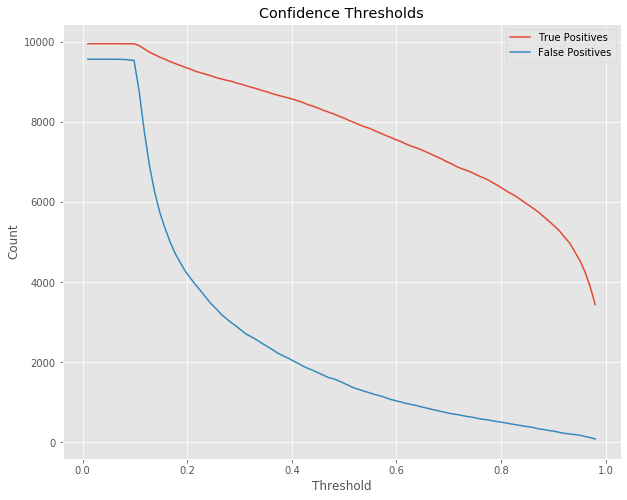

In [28]:

fig, ax0 = plt.subplots(nrows=1,ncols=1, figsize=(10, 8))
ax0.set(title='Confidence Thresholds', xlabel='Threshold', ylabel='Count')
ax0.plot(thresholds_confidence, threshold_confidence_results[:,0], "-", label="%s" % ('True Positives', ))
ax0.plot(thresholds_confidence, threshold_confidence_results[:,1], "-", label="%s" % ('False Positives', ))
# ax0.plot(thresholds_confidence, threshold_confidence_results[:,2], "-", label="%s" % ('False Negatives', ))
ax0.legend(loc="upper right")

fig.savefig('thresholds_conf.pdf')

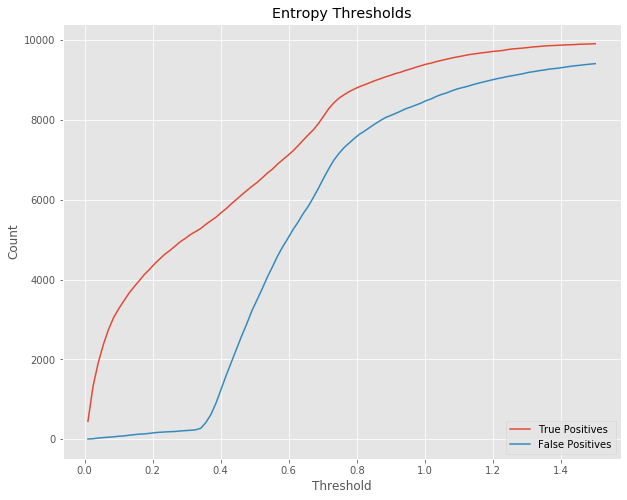

In [29]:
fig, ax0 = plt.subplots(nrows=1,ncols=1, figsize=(10, 8))
ax0.set(title='Entropy Thresholds', xlabel='Threshold', ylabel='Count')
ax0.plot(thresholds_entropy, threshold_entropy_results[:,0], "-", label="%s" % ('True Positives', ))
ax0.plot(thresholds_entropy, threshold_entropy_results[:,1], "-", label="%s" % ('False Positives', ))
# ax0.plot(thresholds_entropy, threshold_entropy_results[:,2], "-", label="%s" % ('False Negatives', ))
ax0.legend(loc="lower right")

fig.savefig('thresholds_entropy.pdf')

### Precision and recall

In [63]:
precision_conf = []
recall_conf = []
for i in threshold_confidence_results:
    prec = i[0] / (i[0] + i[1])
    precision_conf.append(prec)
    rec = i[0] / (i[0] + i[2])
    recall_conf.append(rec)
    
precision_ent = []
recall_ent = []
for i in threshold_entropy_results:
    prec = i[0] / (i[0] + i[1])
    precision_ent.append(prec)
    rec = i[0] / (i[0] + i[2])
    recall_ent.append(rec)

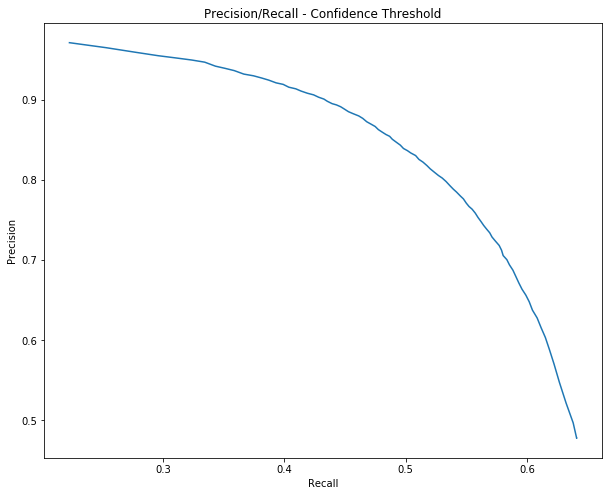

In [66]:
plt.ion()

fig, ax0 = plt.subplots(nrows=1,ncols=1, figsize=(10, 8))

ax0.set(title='Precision/Recall - Confidence Threshold', xlabel='Recall', ylabel='Precision')
ax0.plot(recall_conf, precision_conf, "-")

#fig.savefig('thresholds_conf.pdf')

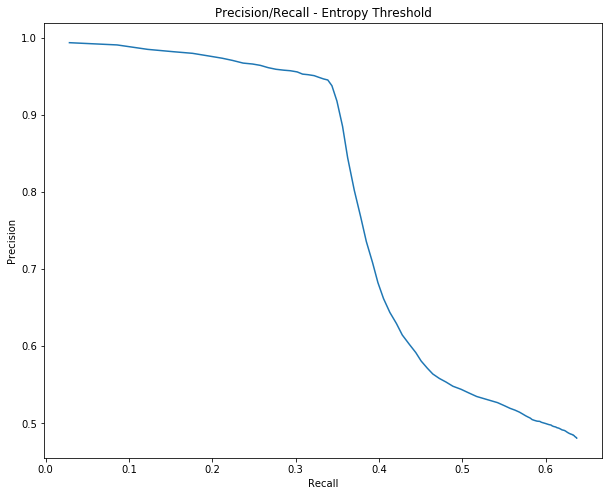

In [67]:
plt.ion()

fig, ax0 = plt.subplots(nrows=1,ncols=1, figsize=(10, 8))

ax0.set(title='Precision/Recall - Entropy Threshold', xlabel='Recall', ylabel='Precision')
ax0.plot(recall_ent, precision_ent, "-")

#fig.savefig('thresholds_conf.pdf')

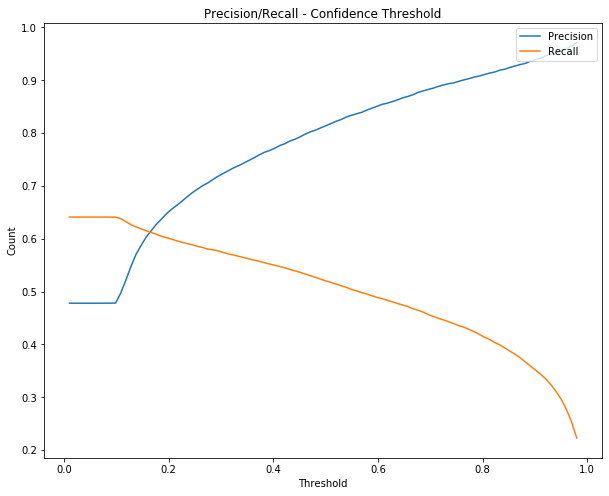

In [68]:
plt.ion()

fig, ax0 = plt.subplots(nrows=1,ncols=1, figsize=(10, 8))

ax0.set(title='Precision/Recall - Confidence Threshold', xlabel='Threshold', ylabel='Count')
ax0.plot(thresholds_confidence, precision_conf, "-", label="%s" % ('Precision', ))
ax0.plot(thresholds_confidence, recall_conf, "-", label="%s" % ('Recall', ))
ax0.legend(loc="upper right")

#fig.savefig('thresholds_conf.pdf')

### ROC Curve

In [ ]:
true_pos_rate_conf = []
false_positive_rate_conf = []
for i in threshold_confidence_results:
    tpr = i[0] / (i[0] + i[2])
    fpr = 1 - tnr
    
    prec = i[0] / (i[0] + i[1])
    precision_conf.append(prec)
    rec = i[0] / (i[0] + i[2])
    recall_conf.append(rec)
    
precision_ent = []
recall_ent = []
for i in threshold_entropy_results:
    prec = i[0] / (i[0] + i[1])
    precision_ent.append(prec)
    rec = i[0] / (i[0] + i[2])
    recall_ent.append(rec)